In [6]:
import pandas as pd ; import numpy as np ; import matplotlib.pyplot as plt ; import tensorflow as tf ; from sklearn.preprocessing import RobustScaler ; from sklearn.metrics import mean_squared_error, r2_score ; from tensorflow.keras.models import Sequential ; from tensorflow.keras.layers import LSTM, Dense ; from tensorflow.keras.models import load_model

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
 
    for i in range(start_index, end_index): 
        indexes = range(i - history_size, i, step)
        data.append(dataset[indexes])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def plot_train_history(history, title) :
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epoch = range(len(loss))
    plt.plot(epoch, loss, 'b', label='Traing loss')
    plt.plot(epoch, val_loss, 'r', label='Val loss')
    plt.legend()
    plt.title(title)
    plt.show()

def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    plt.figure(figsize=(12,6))
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [8]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    
    plt.plot(num_in, np.array(history[:,1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any(): # 값이 있으면...
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend()
    plt.show()


Epoch 1/100

19/19 [==============================] - 6s 77ms/step - loss: 0.4972 - val_loss: 0.6482
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 0.4803 - val_loss: 0.6204
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.4355 - val_loss: 0.5578
Epoch 4/100
19/19 [==============================] - 0s 9ms/step - loss: 0.3730 - val_loss: 0.4337
Epoch 5/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2953 - val_loss: 0.3740
Epoch 6/100
19/19 [==============================] - 0s 10ms/step - loss: 0.2636 - val_loss: 0.3235
Epoch 7/100
19/19 [==============================] - 0s 10ms/step - loss: 0.2454 - val_loss: 0.2944
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 0.2310 - val_loss: 0.2897
Epoch 9/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2155 - val_loss: 0.2662
Epoch 10/100
19/19 [==============================] - 0s 8ms/step - loss: 0.2158 - val_loss: 0.2516
Ep

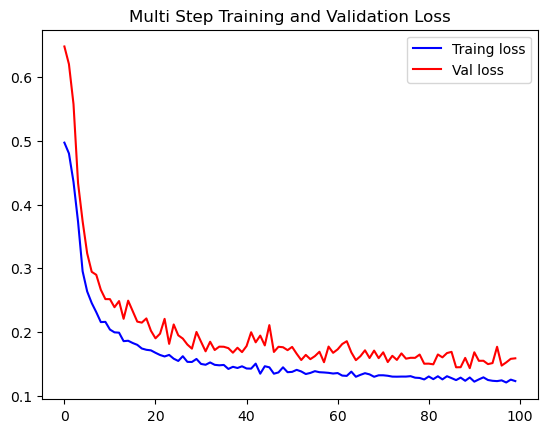

In [9]:

data = pd.read_excel('종합데이터 (1).xlsx')


data['완도_생산량'] = (data['해남_생산량']*(21.3/72.5)).apply(lambda x : int(x))
data['진도_생산량'] = (data['해남_생산량']*(20.9/72.5)).apply(lambda x : int(x))
data['고흥_생산량'] = (data['해남_생산량']*(6.7/72.5)).apply(lambda x : int(x))
data['신안_생산량'] = (data['해남_생산량']*(11.9/72.5)).apply(lambda x : int(x))
data['해남_생산량'] = (data['해남_생산량']*(11.7/72.5)).apply(lambda x : int(x))



name = '진도'
임시 = []

for i in data.columns :
    if name in i :
        임시.append(i)
        
columns = ['연도', 임시[3], 임시[0]]


Jindo_data = data[columns]


Jindo_data.set_index('연도', inplace=True)

dataset = Jindo_data.values


tem_scaler = RobustScaler()
pro_scaler = RobustScaler()


dataset[:, 0] = tem_scaler.fit_transform(dataset[:, 0].reshape(-1, 1)).flatten()
dataset[:, 1] = pro_scaler.fit_transform(dataset[:, 1].reshape(-1, 1)).flatten()

TRAIN_SPLIT = int(len(Jindo_data)*0.8) 
past_history = 12
future_target = 12
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, target=dataset[:,1], start_index=0, end_index=TRAIN_SPLIT, history_size=past_history, target_size=future_target, step=STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, target=dataset[:,1], start_index=TRAIN_SPLIT, end_index=None, history_size=past_history, target_size=future_target, step=STEP, single_step=False)

BATCH_SIZE = 8 ; EPOCH = 100  ; BUFFER_SIZE = 10000 ; STEPS_PER_EPOCH = len(x_train_multi) / BATCH_SIZE 

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()


val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_multi.shape[-2:],return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))

multi_step_model.add(tf.keras.layers.Dense(12))
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss = 'mae')


multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCH, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_multi, validation_steps=5)

plot_train_history(multi_step_history, 'Multi Step Training and Validation Loss')

In [18]:
val_data_multi

<_RepeatDataset element_spec=(TensorSpec(shape=(8, 12, 2), dtype=tf.float64, name=None), TensorSpec(shape=(8, 12), dtype=tf.float64, name=None))>

In [19]:
multi_step_model.predict(val_data_multi, steps=12)

12/12 [==============================] - 1s 4ms/step


array([[ 1.4799303 ,  1.7965133 ,  1.0789493 , ...,  0.0985932 ,
         0.8991052 ,  1.2068741 ],
       [ 1.7470573 ,  0.83187884, -0.05178865, ...,  0.73981386,
         1.2366047 ,  1.8366667 ],
       [ 0.05438859,  0.3585144 ,  0.9312674 , ..., -0.26253787,
        -0.12377932, -0.14429605],
       ...,
       [-0.11224698, -0.16231725, -0.01142669, ..., -0.10271371,
        -0.46840656, -0.15987091],
       [-0.02173216, -0.20374489, -0.15757416, ...,  1.9692332 ,
         1.780015  ,  0.63558495],
       [ 0.8527762 ,  1.4196401 ,  1.8263768 , ..., -0.1525622 ,
        -0.00938751,  0.23523532]], dtype=float32)

In [20]:
for x,y in val_data_multi.take(3) :
    print(x.shape, y.shape)

(8, 12, 2) (8, 12)
(8, 12, 2) (8, 12)
(8, 12, 2) (8, 12)


1/1 [==============================] - 1s 1s/step


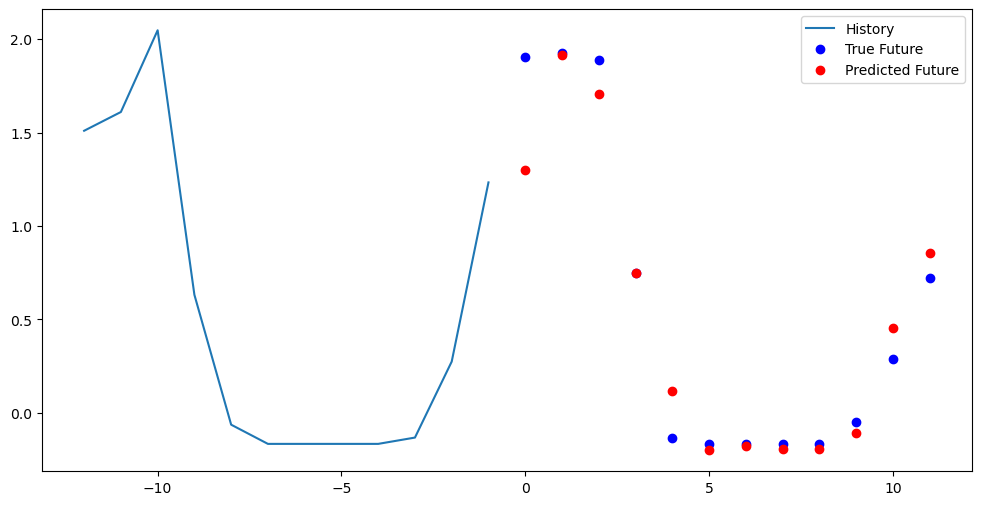

1/1 [==============================] - 0s 49ms/step


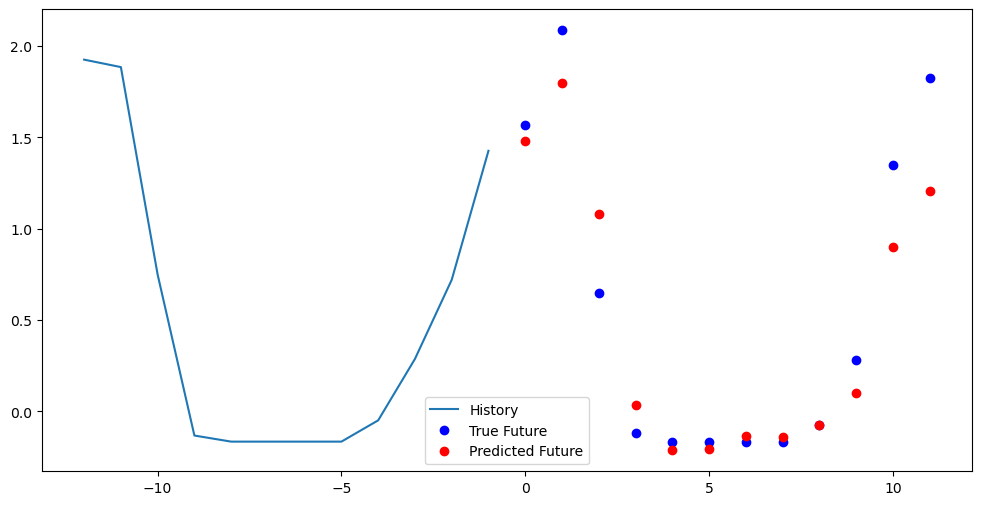

1/1 [==============================] - 0s 50ms/step


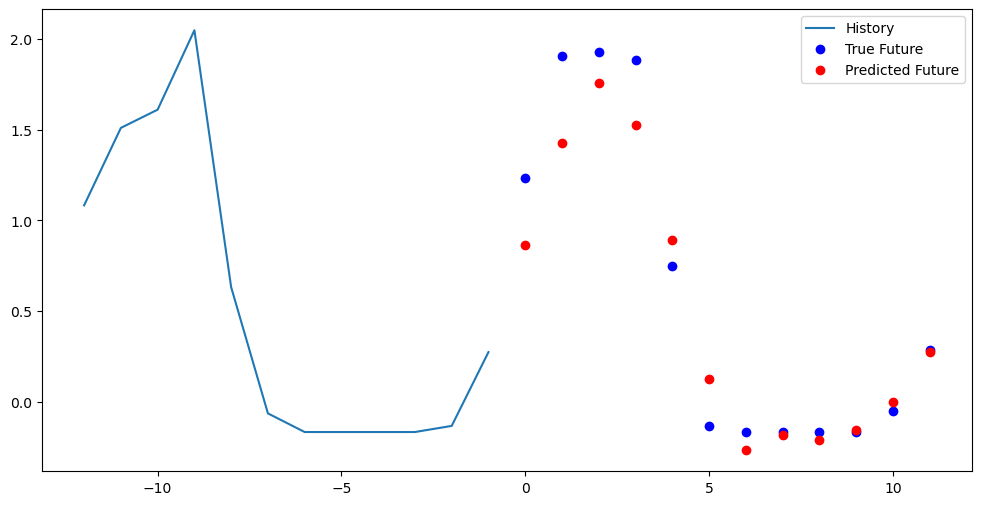

In [21]:
for x, y in val_data_multi.take(3) :
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
    plt.show()

In [22]:
multi_step_model.save('Multi_Step_Production.keras')

In [23]:
test = dataset[-12:,:].reshape(-1,12,2)

In [23]:
test = dataset[-12:,:].reshape(-1,12,2)
y_hat = multi_step_model(test)
pred_prod = pro_scaler.inverse_transform(y_hat)
y_hat_reshape = tf.reshape(y_hat, (12,))
dataset[-12:,1].shape
y_hat_reshape.shape
r2 = r2_score(dataset[-12:,1], y_hat_reshape)
r2

In [24]:
y_hat = multi_step_model(test)

In [25]:
pred_prod = pro_scaler.inverse_transform(y_hat)

In [26]:
y_hat_reshape = tf.reshape(y_hat, (12,))

In [27]:
dataset[-12:,1].shape

(12,)

In [28]:
y_hat_reshape.shape

TensorShape([12])

In [29]:
r2 = r2_score(dataset[-12:,1], y_hat_reshape)

In [30]:
r2

0.9543019062747038

In [31]:
bb =np.concatenate((dataset[-12:,1],np.array([1])))

In [32]:
bb

array([ 0.64627594, -0.11588299, -0.16546687, -0.16546687, -0.16546687,
       -0.1653264 , -0.07416512,  0.28163079,  1.35021245,  1.82427924,
        1.47269726,  1.71591109,  1.        ])